# Прогнозирование риска сердечных заболеваний на основе информации об образе жизни пациента

Сердечно-сосудистые заболевания (ССЗ) являются самой частой причиной смерти по всему земному шару. 
Наиболее эффективной стратегией борьбы с ССЗ является заблаговременное выявление проблем (диагностика) и своевременное начало лечения.

**Задача:** 
обучить модель машинного обучения, которая по табличным данным предсказывает вероятность сердечных заболеваний, проходящих регулярную диспансеризацию.


 *Целевой признак* - `cardio`

Показателем оценки является показатель ROC AUC.

Источник данных: https://www.kaggle.com/competitions/yap15-heart-diseases-predictions/data


**Содержание:**

1. [Предобработка и исследовательский анализ данных](#preprocessing)
2. [Разработка модели ML](#training)
3. [Тестирование модели](#testing)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pickle

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import csv

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [47]:
df_train.head(20)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.0,2,168,62.0,110,80,1,1,0,0,1,0
1,55.0,1,156,85.0,140,90,3,1,0,0,1,1
2,52.0,1,165,64.0,130,70,3,1,0,0,0,1
3,48.0,2,169,82.0,150,100,1,1,0,0,1,1
5,60.0,1,151,67.0,120,80,2,2,0,0,0,0
6,61.0,1,157,93.0,130,80,3,1,0,0,1,0
7,62.0,2,178,95.0,130,90,3,3,0,0,1,1
8,48.0,1,158,71.0,110,70,1,1,0,0,1,0
10,62.0,1,169,80.0,120,80,1,1,0,0,1,0
11,52.0,2,173,60.0,120,80,1,1,0,0,1,0


In [4]:
df_train.shape

(70000, 13)

In [5]:
df_test.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,5,18888,1,154,85.0,130,80,1,1,0,0,1
1,6,19042,2,170,69.0,130,90,1,1,0,0,1
2,7,20432,1,160,70.0,120,75,1,1,0,0,0
3,10,18133,2,185,94.0,130,90,1,1,0,0,1
4,11,16093,2,170,76.0,120,80,1,1,0,0,1


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


<a id="preprocessing"> </a>
### Предобработка и исследовательский анализ данных

In [7]:
df_train.duplicated().sum()

0

Пропусков нет, дубликатов тоже.

In [8]:
df_train.describe().T.iloc[:15]

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


In [9]:
# перевод колонки age в года
df_train['age'] = (df_train['age']/365).round(0)
df_test['age'] = (df_test['age']/365).round(0)

In [10]:
df_train['age'].describe()

count    70000.000000
mean        53.338686
std          6.765294
min         30.000000
25%         48.000000
50%         54.000000
75%         58.000000
max         65.000000
Name: age, dtype: float64

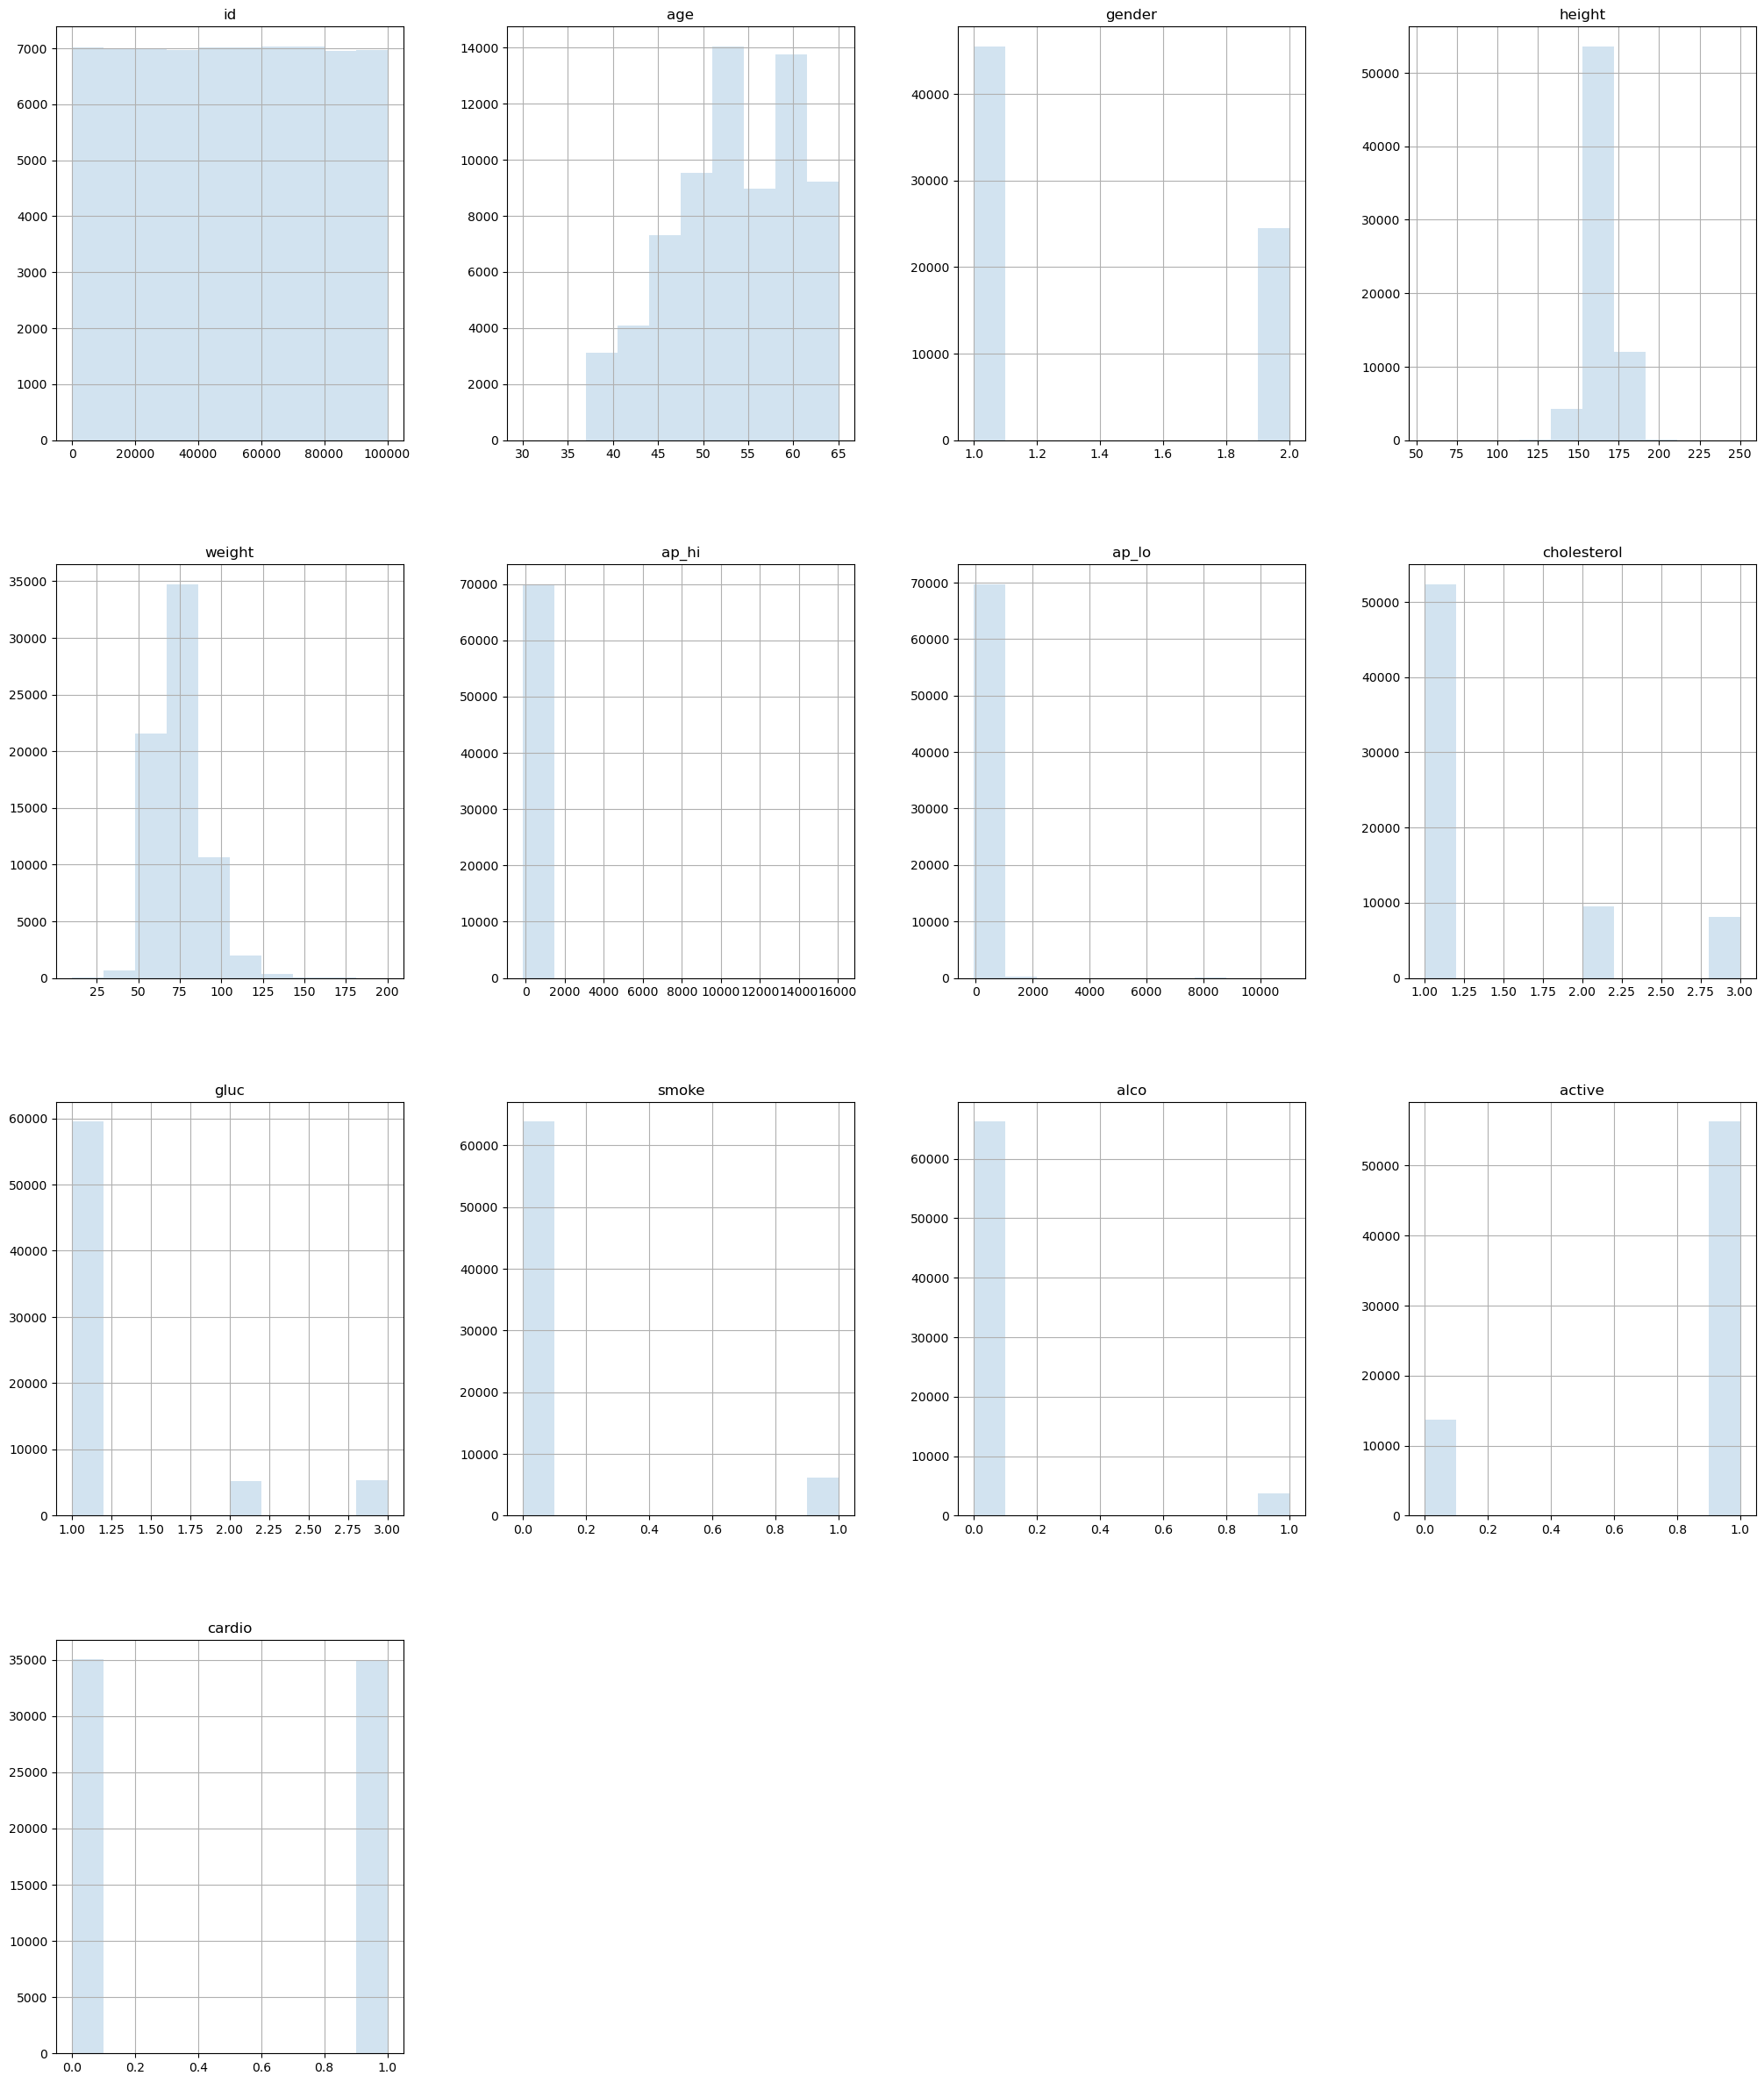

In [11]:
df_train.hist(figsize=(25,30), alpha=0.2)
plt.show()

In [12]:
df_train.gender.value_counts()

1    45530
2    24470
Name: gender, dtype: int64

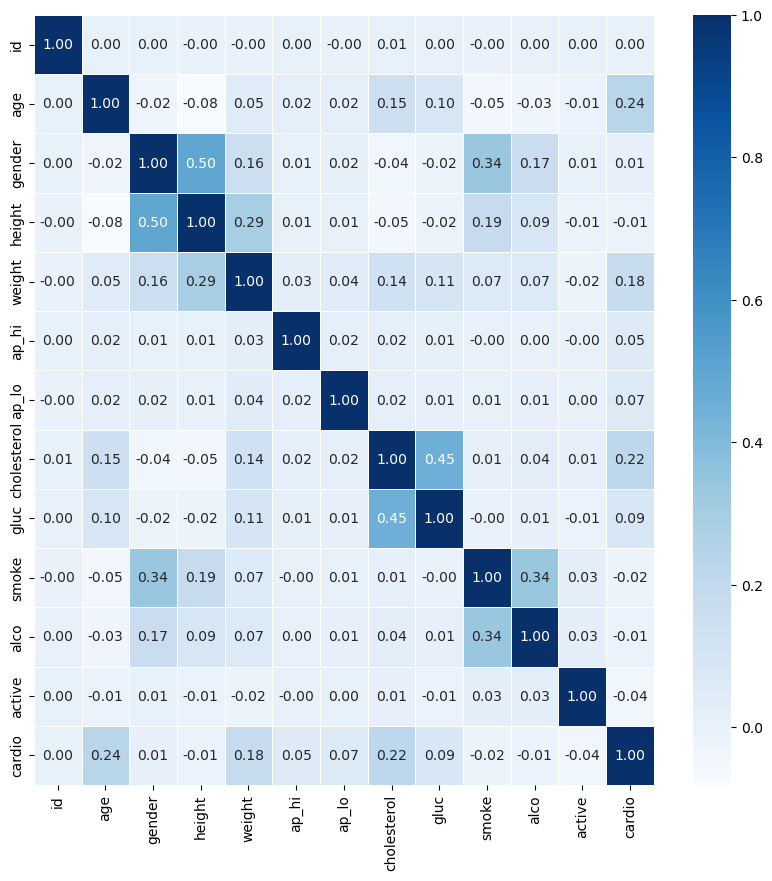

In [13]:
plt.figure(figsize=(10, 10))
sb.heatmap(df_train.corr(), annot=True, fmt=".2f", linewidth=.5, cmap='Blues')
plt.show()

In [14]:
df_train.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [15]:
df_train = df_train.drop(['id'], axis=1)
df_test = df_test.drop(['id'], axis=1)

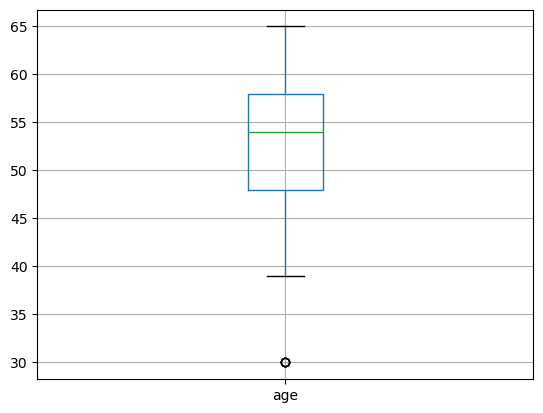

In [16]:
df_train.boxplot('age')
plt.show()

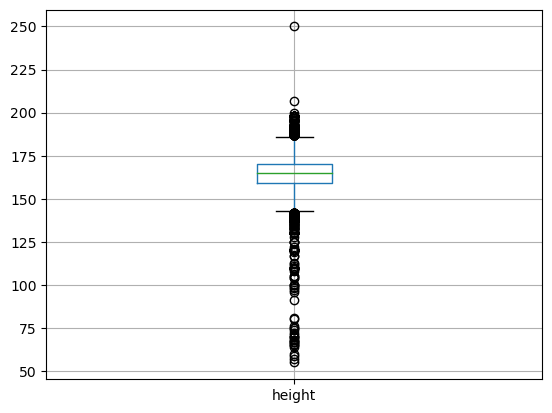

In [17]:
df_train.boxplot('height')
plt.show()

In [18]:
q1 = df_train['height'].quantile(0.25)
q3 = df_train['height'].quantile(0.75)
max_lim = q3 + 1.5 * (q3 - q1)
min_lim = q1 - 1.5 * (q3 - q1)
df_train = df_train[(df_train['height'] < max_lim) & (df_train['height'] > min_lim)]

In [19]:
df_train['height'].describe()

count    69481.000000
mean       164.400469
std          7.621214
min        143.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        186.000000
Name: height, dtype: float64

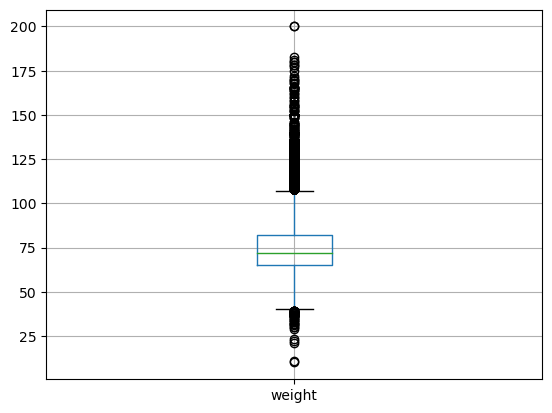

In [20]:
df_train.boxplot('weight')
plt.show()

In [21]:
q1 = df_train['weight'].quantile(0.25)
q3 = df_train['weight'].quantile(0.75)
max_lim = q3 + 1.5 * (q3 - q1)
min_lim = q1 - 1.5 * (q3 - q1)
df_train = df_train[(df_train['weight'] < max_lim) & (df_train['weight'] > min_lim)]

In [22]:
df_train['weight'].describe()

count    67723.000000
mean        73.059601
std         12.407575
min         40.000000
25%         65.000000
50%         72.000000
75%         81.000000
max        107.000000
Name: weight, dtype: float64

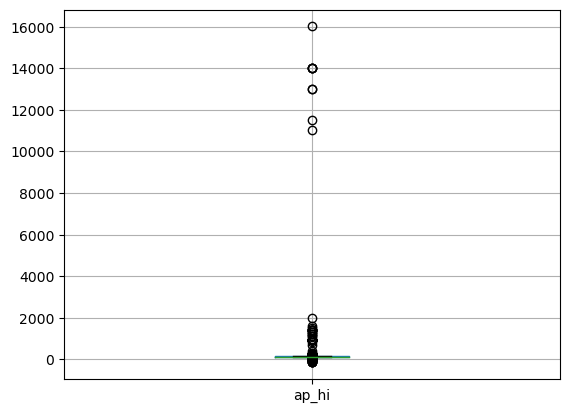

In [23]:
df_train.boxplot('ap_hi')
plt.show()

In [24]:
q1 = df_train['ap_hi'].quantile(0.25)
q3 = df_train['ap_hi'].quantile(0.75)
max_lim = q3 + 1.5 * (q3 - q1)
min_lim = q1 - 1.5 * (q3 - q1)
df_train = df_train[(df_train['ap_hi'] < max_lim) & (df_train['ap_hi'] > min_lim)]

In [25]:
df_train['ap_hi'].describe()

count    64807.000000
mean       126.041153
std         14.179573
min         93.000000
25%        120.000000
50%        120.000000
75%        140.000000
max        169.000000
Name: ap_hi, dtype: float64

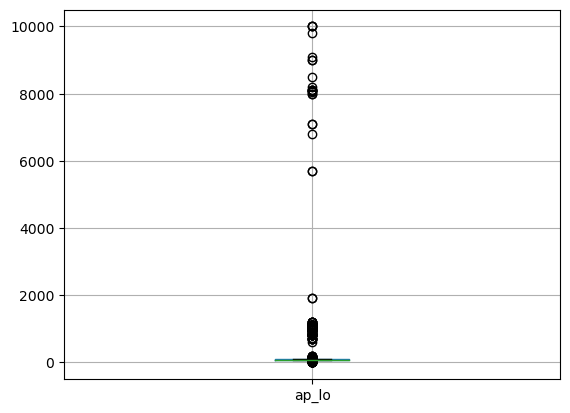

In [26]:
df_train.boxplot('ap_lo')
plt.show()

In [27]:
q1 = df_train['ap_lo'].quantile(0.25)
q3 = df_train['ap_lo'].quantile(0.75)
max_lim = q3 + 1.5 * (q3 - q1)
min_lim = q1 - 1.5 * (q3 - q1)
df_train = df_train[(df_train['ap_lo'] < max_lim) & (df_train['ap_lo'] > min_lim)]

In [28]:
df_train['ap_lo'].describe()

count    61774.000000
mean        81.650921
std          7.566292
min         66.000000
25%         80.000000
50%         80.000000
75%         90.000000
max        104.000000
Name: ap_lo, dtype: float64

In [29]:
df_train.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,61774.000000,61774.000000,61774.000000,61774.000000,61774.000000,61774.000000,61774.000000,61774.000000,61774.000000,61774.000000,61774.000000,61774.000000
mean,53.397255,1.348836,164.421634,73.158325,126.181727,81.650921,1.355846,1.220093,0.086428,0.052012,0.804319,0.491841
std,6.739640,0.476606,7.526350,12.247123,13.692507,7.566292,0.674070,0.567375,0.280997,0.222053,0.396727,0.499937
min,30.000000,1.000000,143.000000,40.000000,95.000000,66.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,49.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,58.000000,2.000000,170.000000,81.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,65.000000,2.000000,186.000000,107.000000,169.000000,104.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
# доля удаления всех выбросов
(70000 - 61774)/70000

0.11751428571428571

In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61774 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          61774 non-null  float64
 1   gender       61774 non-null  int64  
 2   height       61774 non-null  int64  
 3   weight       61774 non-null  float64
 4   ap_hi        61774 non-null  int64  
 5   ap_lo        61774 non-null  int64  
 6   cholesterol  61774 non-null  int64  
 7   gluc         61774 non-null  int64  
 8   smoke        61774 non-null  int64  
 9   alco         61774 non-null  int64  
 10  active       61774 non-null  int64  
 11  cardio       61774 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 6.1 MB


<a id="training"> </a>
### Разработка модели ML


In [32]:
share = df_train['cardio'].value_counts(normalize=True)

In [33]:
share

0    0.508159
1    0.491841
Name: cardio, dtype: float64

In [34]:
features_train = df_train.drop(['cardio'], axis=1)
target_train= df_train['cardio']

In [35]:
# модель решающего дерева
np.random.seed(42)

param_distributions = {
    'max_depth': range (5, 35, 10),
    'max_features': range (2, 10),
    'min_samples_split': range (2, 20, 2),
    'min_samples_leaf': range (1, 20, 2)
}
clf = DecisionTreeClassifier()
search = RandomizedSearchCV(clf, param_distributions, n_iter=20, cv=5)
search.fit(features_train, target_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=20,
                   param_distributions={'max_depth': range(5, 35, 10),
                                        'max_features': range(2, 10),
                                        'min_samples_leaf': range(1, 20, 2),
                                        'min_samples_split': range(2, 20, 2)})

In [36]:
search.best_params_

{'min_samples_split': 16,
 'min_samples_leaf': 3,
 'max_features': 7,
 'max_depth': 5}

In [37]:
%%time
np.random.seed(42)

clf = DecisionTreeClassifier(min_samples_split = 16,  min_samples_leaf = 3, max_depth=5, max_features=7)
clf.fit(features_train, target_train)

probabilities_train = clf.predict_proba(features_train)
probabilities_one_train = probabilities_train[:, 1]

auc_roc = roc_auc_score(target_train, probabilities_one_train)
print('AUC_ROC:', auc_roc)

AUC_ROC: 0.7798770893823046
CPU times: user 43.3 ms, sys: 1.64 ms, total: 45 ms
Wall time: 43.9 ms


In [38]:
# модель случайный лес
np.random.seed(42)

param_distributions = {
    'max_depth': range (5, 35, 10),
    'n_estimators': range (10, 101, 10),
    'min_samples_split': range (2, 20, 2),
    'min_samples_leaf': range (1, 20, 2)
}
clf = RandomForestClassifier()
search = RandomizedSearchCV(clf, param_distributions, n_iter=20, cv=5)
search.fit(features_train, target_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': range(5, 35, 10),
                                        'min_samples_leaf': range(1, 20, 2),
                                        'min_samples_split': range(2, 20, 2),
                                        'n_estimators': range(10, 101, 10)})

In [39]:
search.best_params_

{'n_estimators': 30,
 'min_samples_split': 10,
 'min_samples_leaf': 13,
 'max_depth': 15}

In [40]:
%%time
np.random.seed(42)

clf = RandomForestClassifier(n_estimators=60, min_samples_split = 10, min_samples_leaf = 13, max_depth=15)
clf.fit(features_train, target_train)

probabilities_train = clf.predict_proba(features_train)
probabilities_one_train = probabilities_train[:, 1]

auc_roc = roc_auc_score(target_train, probabilities_one_train)
print('AUC_ROC:', auc_roc)

AUC_ROC: 0.8265237898610815
CPU times: user 1.73 s, sys: 4.56 ms, total: 1.73 s
Wall time: 1.73 s


Лучший auc_roc показала модель RandomForestClassifier, тестирование будем проводить на этой модели.

In [41]:
features_train.shape

(61774, 11)

In [42]:
df_test.shape

(30000, 11)

<a id="testing"> </a>
### Тестирование модели

In [43]:
%%time
np.random.seed(42)

clf_best = RandomForestClassifier(n_estimators=60, min_samples_split = 10, min_samples_leaf = 13, max_depth=15)
clf_best.fit(features_train, target_train)

probabilities_test = clf_best.predict_proba(df_test)
probabilities_one_test = probabilities_test[:, 1]

CPU times: user 1.56 s, sys: 7.3 ms, total: 1.57 s
Wall time: 1.57 s


In [44]:
from pickle import dump, load

In [45]:
with open ("/Users/olgakylosova/PycharmProjects/Heart diseases prediction/model.pcl", "wb") as fid:
    dump(clf_best, fid)